# CRNN from scratch using TensorFlow

The goal of this notebook is to take what I've learned from the [Udacity Deep Learning course](https://www.udacity.com/course/deep-learning--ud730) and apply it to training an algorithm that can perform image to text translation on the [Stanford Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/), successfully recognizing street address numbers in real-world images.

Because I've recently gotten very excited about LSTMs, I'll be attempting this task using a [CRNN](https://arxiv.org/pdf/1507.05717.pdf), connecting the output of a convolutional net to an RNN decoder.

In [4]:
import os
import sys
from __future__ import print_function
import random
import numpy as np
import tensorflow as tf
import scipy.io
import gzip
import tarfile
import h5py
from PIL import Image
import six.moves.cPickle as pickle
from six.moves import urllib
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

### Data Prep

Many thanks to Imad Ali who gave a [great example](https://github.com/imadmali/svhn-format1) of how to preprocess this dataset using Python's `h5py` library. The next few cells are adapted from his work.

In [5]:
data_dir = '../data'

# Download the SVHN dataset if it is not present
def check_dataset(dataset):
    # Check if dataset is in the data directory.
    new_path = os.path.join(data_dir, dataset)
    if (not os.path.isdir(data_dir)):
        os.mkdir(data_dir)
    if (not os.path.isfile(new_path)):
        origin = ('http://ufldl.stanford.edu/housenumbers/' + dataset)
        print('Downloading data from %s' % origin)
        urllib.request.urlretrieve(origin, new_path)
    return new_path

print(check_dataset('train.tar.gz'))
print(check_dataset('test.tar.gz'))

../data/train.tar.gz
../data/test.tar.gz


In [7]:
image_size = 32
num_channels = 3

def format_data(dataset):
    print('... processing data (should only occur when downloading for the first time)')
    # Unzip data from scratch
    data_type = os.path.splitext(os.path.splitext(dataset)[0])[0]
    unzipped_path = os.path.join(data_dir, data_type)
    if os.path.exists(unzipped_path):
        shutil.rmtree(unzipped_path)
    tar = tarfile.open(os.path.join(data_dir, dataset), 'r:gz')
    tar.extractall(data_dir)

    # Access label information in digitStruct.mat
    f = h5py.File(os.path.join(data_dir, data_type, 'digitStruct.mat'), 'r')
    digit_struct_name = f['digitStruct']['name']
    digit_struct_bbox = f['digitStruct']['bbox']

    def getName(n):
        return ''.join([chr(c[0]) for c in f[digit_struct_name[n][0]].value])

    def bboxHelper(attr):
        if (len(attr) > 1):
            attr = [f[attr.value[j].item()].value[0][0] for j in range(len(attr))]
        else:
            attr = [attr.value[0][0]]
        return attr

    def getBbox(n):
        bbox = {}
        bb = digit_struct_bbox[n].item()
        bbox['height'] = bboxHelper(f[bb]["height"])
        bbox['label'] = bboxHelper(f[bb]["label"])
        bbox['left'] = bboxHelper(f[bb]["left"])
        bbox['top'] = bboxHelper(f[bb]["top"])
        bbox['width'] = bboxHelper(f[bb]["width"])
        return bbox

    # Process bbox
    print('... creating image box bound dict for %s data' % data_type)
    image_dict = {}
    for i in range(len(digit_struct_name)):
        image_dict[getName(i)] = getBbox(i)
        if (i % 2000 == 0):
            print('\timage dict processing: %i/%i complete' % (i, len(digit_struct_name)))
    print('... dict processing complete')

    # Process the data
    print('... processing image data and labels')
    names = [item for item in os.listdir(unzipped_path) if item.endswith('.png')]

    x, y = [], []
    for i in range(len(names)):
        y.append(image_dict[names[i]]['label'])
        image = Image.open(unzipped_path + '/' + names[i])
        # Calculate the total bounding box from the exterior corners of all bounding boxes
        left = int(min(image_dict[names[i]]['left']))
        upper = int(min(image_dict[names[i]]['top']))
        right = int(max(image_dict[names[i]]['left'])) + int(max(image_dict[names[i]]['width']))
        lower = int(max(image_dict[names[i]]['top'])) + int(max(image_dict[names[i]]['height']))
        image = image.crop(box = (left, upper, right, lower))
        image = image.resize([image_size, image_size])
        image_array = np.array(image)
        # Normalize mean and standard deviation
        image_array = (image_array - 255. / 2) / 255.
        x.append(image_array)
        if (i % 2000 == 0):
            print('\timage processing: %i/%i complete' % (i, len(names)))
    print('... image processing complete')

    # Save data
    print('... pickling data')
    out = {'labels': y, 'images': x}
    out_path = os.path.join(data_dir, data_type + 'pkl.gz')
    p = gzip.open(out_path, 'wb')
    pickle.dump(out, p)
    p.close()

    tar.close()
    
    # clean up (delete test/train folders that were used to create the pickled data)
    shutil.rmtree(unzipped_path)

Only format the data if the processed pickle files don't exist.

In [8]:
if (not os.path.isfile(os.path.join(data_dir, 'trainpkl.gz'))):
    format_data('train.tar.gz')

f_train = gzip.open(os.path.join(data_dir, 'trainpkl.gz'), 'rb')
train_data = pickle.load(f_train)
f_train.close()

if (not os.path.isfile(os.path.join(data_dir, 'testpkl.gz'))):
    format_data('test.tar.gz')

f_test = gzip.open(os.path.join(data_dir, 'testpkl.gz'), 'rb')
test_data = pickle.load(f_test)
f_test.close()

In [9]:
label_length = 6

# Convert data format
def convert_data_format(data):
    images = data.pop('images')
    X = np.array(images)

    labels = data.pop('labels')
    for i in range(len(labels)):
        l = len(labels[i])-1
        zeros = np.zeros(label_length - l - 1).tolist()
        labels[i].extend(zeros)
    y = np.array(labels)
    
    return (X,y)

train_set = convert_data_format(train_data)
train_set_len = len(train_set[1])

# Extract validation dataset from train dataset (10% of the train_set)
valid_set = [x[-(train_set_len//10):] for x in train_set]
train_set = [x[:-(train_set_len//10)] for x in train_set]
test_set = convert_data_format(test_data)

`train_set`, `valid_set`, and `test_set` each contain a list `['images', 'labels']`.
* `'images'` is a 4D numpy array of dimensions num_images x height x width x channels (RGB)
* `'labels'` is a 2D numpy array where each row is a house number and each element of that row is a digit. The rows
  are padded at a length of 6 digits where the number `0` represents the padding, and the number `10` represents the
  digit `0`.

In [10]:
print(train_set[0].shape, train_set[1].shape)
print(valid_set[0].shape, valid_set[1].shape)
print(test_set[0].shape, test_set[1].shape)

(30062, 32, 32, 3) (30062, 6)
(3340, 32, 32, 3) (3340, 6)
(13068, 32, 32, 3) (13068, 6)


As a sanity check, let's display an image from the test set. The image will look odd because of the mean and standard deviation normalization we did in the `format_data()` method.

[  2.  10.  10.   0.   0.   0.]


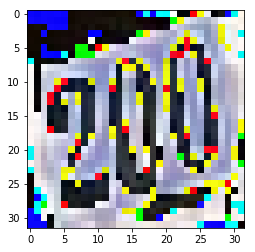

In [11]:
data_index = 994
plt.imshow(test_set[0][data_index])
print(test_set[1][data_index])

From these datasets, we need to build batches that can be read by convolutional and LSTM layers.

In [12]:
batch_size = 16
vocabulary_size = 12 # buffer, digits 1-9, 0 digit, and a GO token for the lstm, in that order

class BatchGenerator(object):
  def __init__(self, data_set, batch_size):
    self._images = data_set[0]
    self._labels = data_set[1]
    self._dataset_size = data_set[1].shape[0]
    self._label_size = data_set[1].shape[1]
    self._batch_size = batch_size
    self._cursor = 0
  
  def next(self):
    """Generate a single batch from the current cursor position in the data."""
    image_batch = []
    for b in range(self._batch_size):
        cursor = (self._cursor + b) % self._dataset_size
        image_batch.append(self._images[cursor])
    label_batch = []
    for i in range(self._label_size):
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float64)
        for b in range(self._batch_size):
            cursor = (self._cursor + b) % self._dataset_size
            batch[b, int(self._labels[cursor][i])] = 1.0
        label_batch.append(batch)
    self._cursor = (self._cursor + self._label_size) % self._dataset_size
    return [np.array(image_batch), label_batch]

In [13]:
test_batches = BatchGenerator(test_set, batch_size)
batch = test_batches.next()
print(batch[0].shape, len(batch[1]), batch[1][0].shape)

(16, 32, 32, 3) 6 (16, 12)


### Building the Computation Graph and Training

The following are a couple of utility functions to make it easier to print training outputs:

In [14]:
def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

def sample_distribution(distribution):
  """Sample one element from a distribution assumed to be an array of normalized
  probabilities.
  """
  r = random.uniform(0, 1)
  s = 0
  for i in range(len(distribution)):
    s += distribution[i]
    if s >= r:
      return i
  return len(distribution) - 1

Now let's build the model: first, the convolutional layer, and then the (slightly simplified) LSTM cell.
Notice that the output of an LSTM cell is used as the input of the subsequent cell intead of using the correct label as the input, a competing architecture.

In [15]:
conv_patch_size = 5
conv_depth = 16
conv_num_hidden = 64
lstm_num_nodes = 64

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    valid_dataset = tf.placeholder(
        tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    go_token = tf.constant(
        np.c_[np.zeros((batch_size, vocabulary_size-1)), np.ones(batch_size)], dtype=tf.float32)

    # Label data to be used as outputs
    train_labels = list()
    for _ in range(label_length):
        train_labels.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    valid_labels = list()
    for _ in range(label_length):
        valid_labels.append(tf.placeholder(tf.float32, shape=[batch_size,vocabulary_size]))
    
    # CNN variables
    layer1_weights = tf.Variable(tf.truncated_normal(
        [conv_patch_size, conv_patch_size, num_channels, conv_depth], stddev=0.1))
    layer1_biases = tf.Variable(tf.zeros([conv_depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
        [conv_patch_size, conv_patch_size, conv_depth, conv_depth], stddev=0.1))
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[conv_depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
        [image_size // 4 * image_size // 4 * conv_depth, conv_num_hidden], stddev=0.1))
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[conv_num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
        [conv_num_hidden, lstm_num_nodes], stddev=0.1))
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[lstm_num_nodes]))

    # LSTM variables
    # Combined input, output, and bias matrices of the four gates [input, forget, memory, output]
    combined_i = tf.Variable(tf.truncated_normal([vocabulary_size, lstm_num_nodes*4], -0.1, 0.1))
    combined_o = tf.Variable(tf.truncated_normal([lstm_num_nodes, lstm_num_nodes*4], -0.1, 0.1))
    combined_b = tf.Variable(tf.zeros([1, lstm_num_nodes * 4]))
    # Variable saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, lstm_num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = tf.Variable(tf.truncated_normal([lstm_num_nodes, vocabulary_size], -0.1, 0.1))
    b = tf.Variable(tf.zeros([vocabulary_size]))
    
    # Models
    def cnn_model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        pooling = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pooling, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        pooling = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pooling.get_shape().as_list()
        reshape = tf.reshape(pooling, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
        return tf.matmul(hidden, layer4_weights) + layer4_biases

    def lstm_cell(i, o, state):
        """Similar to http://arxiv.org/pdf/1402.1128v1.pdf without various connections
        between the previous state and the gates."""
        input, forget, memory, output = tf.split(
            tf.matmul(i, combined_i) + tf.matmul(o, combined_o) + combined_b,
            num_or_size_splits=4, axis=1)
        input_gate  = tf.sigmoid(input)
        forget_gate = tf.sigmoid(forget)
        output_gate = tf.sigmoid(output)
        state = forget_gate * state + input_gate * tf.tanh(memory)
        return output_gate * tf.tanh(state), state
    
    def crnn_model(input_data):
        # Convolutional step
        conv_state = cnn_model(input_data)

        # Unrolled LSTM loop.
        outputs = list()
        output = saved_output
        state = conv_state
        input = go_token
        for _ in range(label_length):
            output, state = lstm_cell(input, output, state)
            outputs.append(output)
            # Feed output back to input instead of using corrective inputs
            input = tf.nn.xw_plus_b(output, w, b)
            # input = sample(tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))) # do we 1-hot inputs?

        # Classifier.
        logits = tf.nn.xw_plus_b(tf.concat(outputs, 0), w, b)
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                labels=tf.concat(train_labels, 0), logits=logits))
        
        return logits, loss
    
    # Training loop
    train_logits, train_loss = crnn_model(train_dataset)

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(train_loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
    optimizer = optimizer.apply_gradients(zip(gradients, v), global_step=global_step)

    # Validation loop
    valid_logits, _ = crnn_model(valid_dataset)

    # Predictions
    train_prediction = tf.nn.softmax(train_logits)
    valid_prediction = tf.nn.softmax(valid_logits)

Now let's train the network using the validation set perplexity and occassionally printing a small subset of the validation predictions to keep track of training progress.

In [16]:
train_batches = BatchGenerator(train_set, batch_size)
valid_batches = BatchGenerator(valid_set, batch_size)

# Remember one validation batch for printing outputs
v_batch = valid_batches.next()

valid_size = valid_set[0].shape[0]

num_steps = 4001
summary_frequency = 100

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(label_length):
            feed_dict[train_labels[i]] = batches[1][i]
        feed_dict[train_dataset] = batches[0]
        _, l, predictions, lr = session.run(
            [optimizer, train_loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f learning rate: %f' %
                  (step, mean_loss, lr))
            mean_loss = 0

            # Calculate the minibatch perplexity
            labels = np.concatenate(batches[1])
            print('Minibatch perplexity: %.2f' %
                  float(np.exp(logprob(predictions, labels))))
            
            # Print small subset of validation batch predictions
            if step % (summary_frequency * 5) == 0:
                feed_dict = dict()
                for i in range(label_length):
                    feed_dict[valid_labels[i]] = v_batch[1][i]
                feed_dict[valid_dataset] = v_batch[0]
                prediction = valid_prediction.eval(feed_dict)
                print('\tPREDICTED\t\tACTUAL', end='\n')
                for i in range(8):
                    # predicted = np.argmax(prediction[i::16],1)
                    predicted = [sample_distribution(digit) for digit in prediction[i::16]]
                    actual = [np.argmax(digit[i]) for digit in np.array(v_batch[1])]
                    print('\t', end='')
                    print(list(predicted), end='\t')
                    print(actual, end='\n')

                # Measure validation set perplexity.
                valid_logprob = 0
                for _ in range(valid_size // batch_size):                
                    b = valid_batches.next()
                    feed_dict = dict()
                    for i in range(label_length):
                        feed_dict[valid_labels[i]] = b[1][i]
                    feed_dict[valid_dataset] = b[0]
                    predictions = valid_prediction.eval(feed_dict)
                    labels = np.concatenate(b[1])
                    valid_logprob = valid_logprob + logprob(predictions, labels)
                print('\tValidation set perplexity: %.2f' %
                      float(np.exp(valid_logprob / valid_size)))

Initialized
Average loss at step 0: 2.456678 learning rate: 1.000000
Minibatch perplexity: 11.67
	PREDICTED		ACTUAL
	[0, 5, 7, 0, 11, 0]	[6, 4, 2, 0, 0, 0]
	[0, 0, 0, 0, 0, 10]	[1, 6, 3, 0, 0, 0]
	[9, 0, 0, 3, 0, 10]	[6, 4, 0, 0, 0, 0]
	[3, 11, 0, 1, 6, 8]	[8, 0, 0, 0, 0, 0]
	[0, 10, 0, 0, 0, 0]	[3, 2, 0, 0, 0, 0]
	[1, 0, 3, 0, 3, 3]	[1, 2, 0, 0, 0, 0]
	[0, 0, 5, 3, 0, 10]	[3, 10, 0, 0, 0, 0]
	[3, 8, 1, 0, 0, 0]	[2, 8, 0, 0, 0, 0]
	Validation set perplexity: 1.09
Average loss at step 100: 1.068513 learning rate: 1.000000
Minibatch perplexity: 2.33
Average loss at step 200: 0.997969 learning rate: 1.000000
Minibatch perplexity: 2.62
Average loss at step 300: 0.959504 learning rate: 1.000000
Minibatch perplexity: 2.27
Average loss at step 400: 0.951943 learning rate: 1.000000
Minibatch perplexity: 2.73
Average loss at step 500: 0.912625 learning rate: 1.000000
Minibatch perplexity: 2.29
	PREDICTED		ACTUAL
	[3, 9, 9, 0, 0, 0]	[6, 4, 2, 0, 0, 0]
	[3, 1, 10, 0, 0, 0]	[1, 6, 3, 0, 0, 0]
	[1,

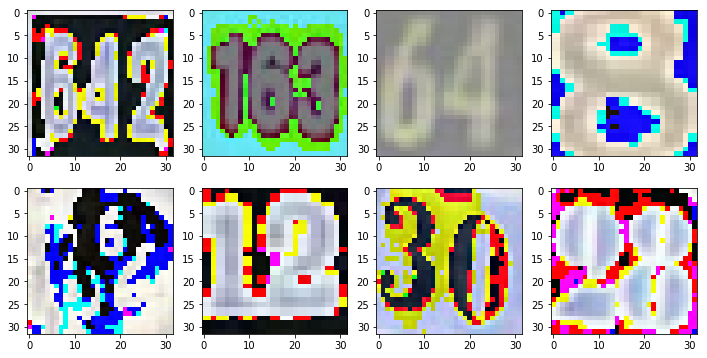

In [17]:
fig = plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1).imshow(v_batch[0][i])
plt.show()

### Final Thoughts

Compared to the architecture outlined by Shi, Bai, and Yao, who tackle the same problem in [this paper](https://arxiv.org/pdf/1507.05717.pdf), it's actually remarkable that my simplified model was able to exhibit convergence and diminishing perplexity.

Here are some crucial components from the paper that I did not use:
* Bidirectional LSTMs
* Multilayered LSTMS
* Replacing the CNN fully connected layer with a spatially ordered feature sequence
* A transcription layer

I also imagine that feeding the correct labels as inputs to each cell of the LSTM layer would speed up convergence (though that can sometimes hurt the robustness of the final model).

There's also an interesting question of how to initialize the first LSTM cell's input of prior output. In the batch processing of sequential text, it's often advised to make sure that output values persist across batches to provide the subsequent batch with a glipse of the prior batch, but in this case, I decided to zero out that input for each batch because it seemed that there was no obvious connection between one batch of images and another.

What this notebook shows is that __there is enough latent information in the fully-connected output of the convolutional network to drive the recurrent layer__ to produce some correct answers.

##### Future Directions

Given more time, I'd obviously like to adapt more components from the architecture outlined in the paper.

Also, one hypothesis based on my printed validation examples is that my architecture struggles with longer sequences, so the introduction of spatially ordered feature sequences at the CNN layer would probably go a long way in better utilizing the sequence capabilities of LSTMs. I also think it would be worth experimenting with a modified LSTM architecture in which the hidden state produced by the CNN is fed to every cell of the recurrent layer, but a BiLSTM may also be sufficient.